## 1. Read SST Reanalysis
You can download ERSST Reanalysis & Korea station data on below URL : 

URL : https://www.dropbox.com/sh/nbt8zer5r0yex92/AAAVw-MYUggHOBwCWbzUGKrWa?dl=0

In [8]:
## Modules for Calculate netCDF 
import numpy    as np
import xarray   as xr
import netCDF4 
import pandas as pd

## Modules for caculating statistics
from scipy   import stats, signal
from sklearn import linear_model

## Modules for plottings
import matplotlib.pyplot as plt 
import matplotlib.colorbar as cb
from mpl_toolkits.basemap import Basemap, shiftgrid

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

## Modules for modulating systems
import os
import warnings
warnings.filterwarnings('ignore')

In [9]:
f = xr.open_dataset("./DJF_nino34.nc")
nino34 = f["DJFnino34"]

f = xr.open_dataset("./anom_SST.nc")
anom_SST = f["anom_SST"]
lon =  f["lon"].values
lat =  f["lat"].values

## DJF SST Composite with Nino3.4(over 1 std)

In [10]:
## calculate SST of each season
SST_season_all = anom_SST.where(anom_SST['time.season'] == 'DJF')
SST_season     = SST_season_all.rolling(min_periods=3, center=True, time=3).mean()
SST_season[0]  = SST_season_all[0:2].mean()
SST_season     = SST_season.groupby('time.year').mean('time')
SST_season     = SST_season[1::]

##year index(DJF nino34 index over 1 std)
nino34 = nino34 / nino34.std()
ind_ts  =  np.where(nino34 >= 1.0)[0]

##composite
comp = SST_season[ind_ts].mean("year")

In [11]:
#Bootstrap
nboot = 10000
tmp_sig_lev = 0.05

n1_dims = SST_season.values.shape; n1 = n1_dims[0]
n2_dims = SST_season[ind_ts].values.shape; n2 = n2_dims[0]
ny = n1_dims[1]; nx = n1_dims[2]
boot = np.empty([nboot,ny,nx])
n_tail = round(nboot*(0+tmp_sig_lev/2.0))
n_head = round(nboot*(1-tmp_sig_lev/2.0))
    
for i in range(nboot):
    random_id = np.random.choice( np.arange(0,n1,1), replace = True, size = n2 )
    boot[i,:,:] = SST_season[random_id,:,:].mean( axis = 0 )

boot_sorted = np.sort( boot, axis = 0 )
boot_tail = boot_sorted[n_tail,:,:]
boot_head = boot_sorted[n_head,:,:]
signi = np.where( (comp > boot_head) | (comp < boot_tail), comp, np.nan )

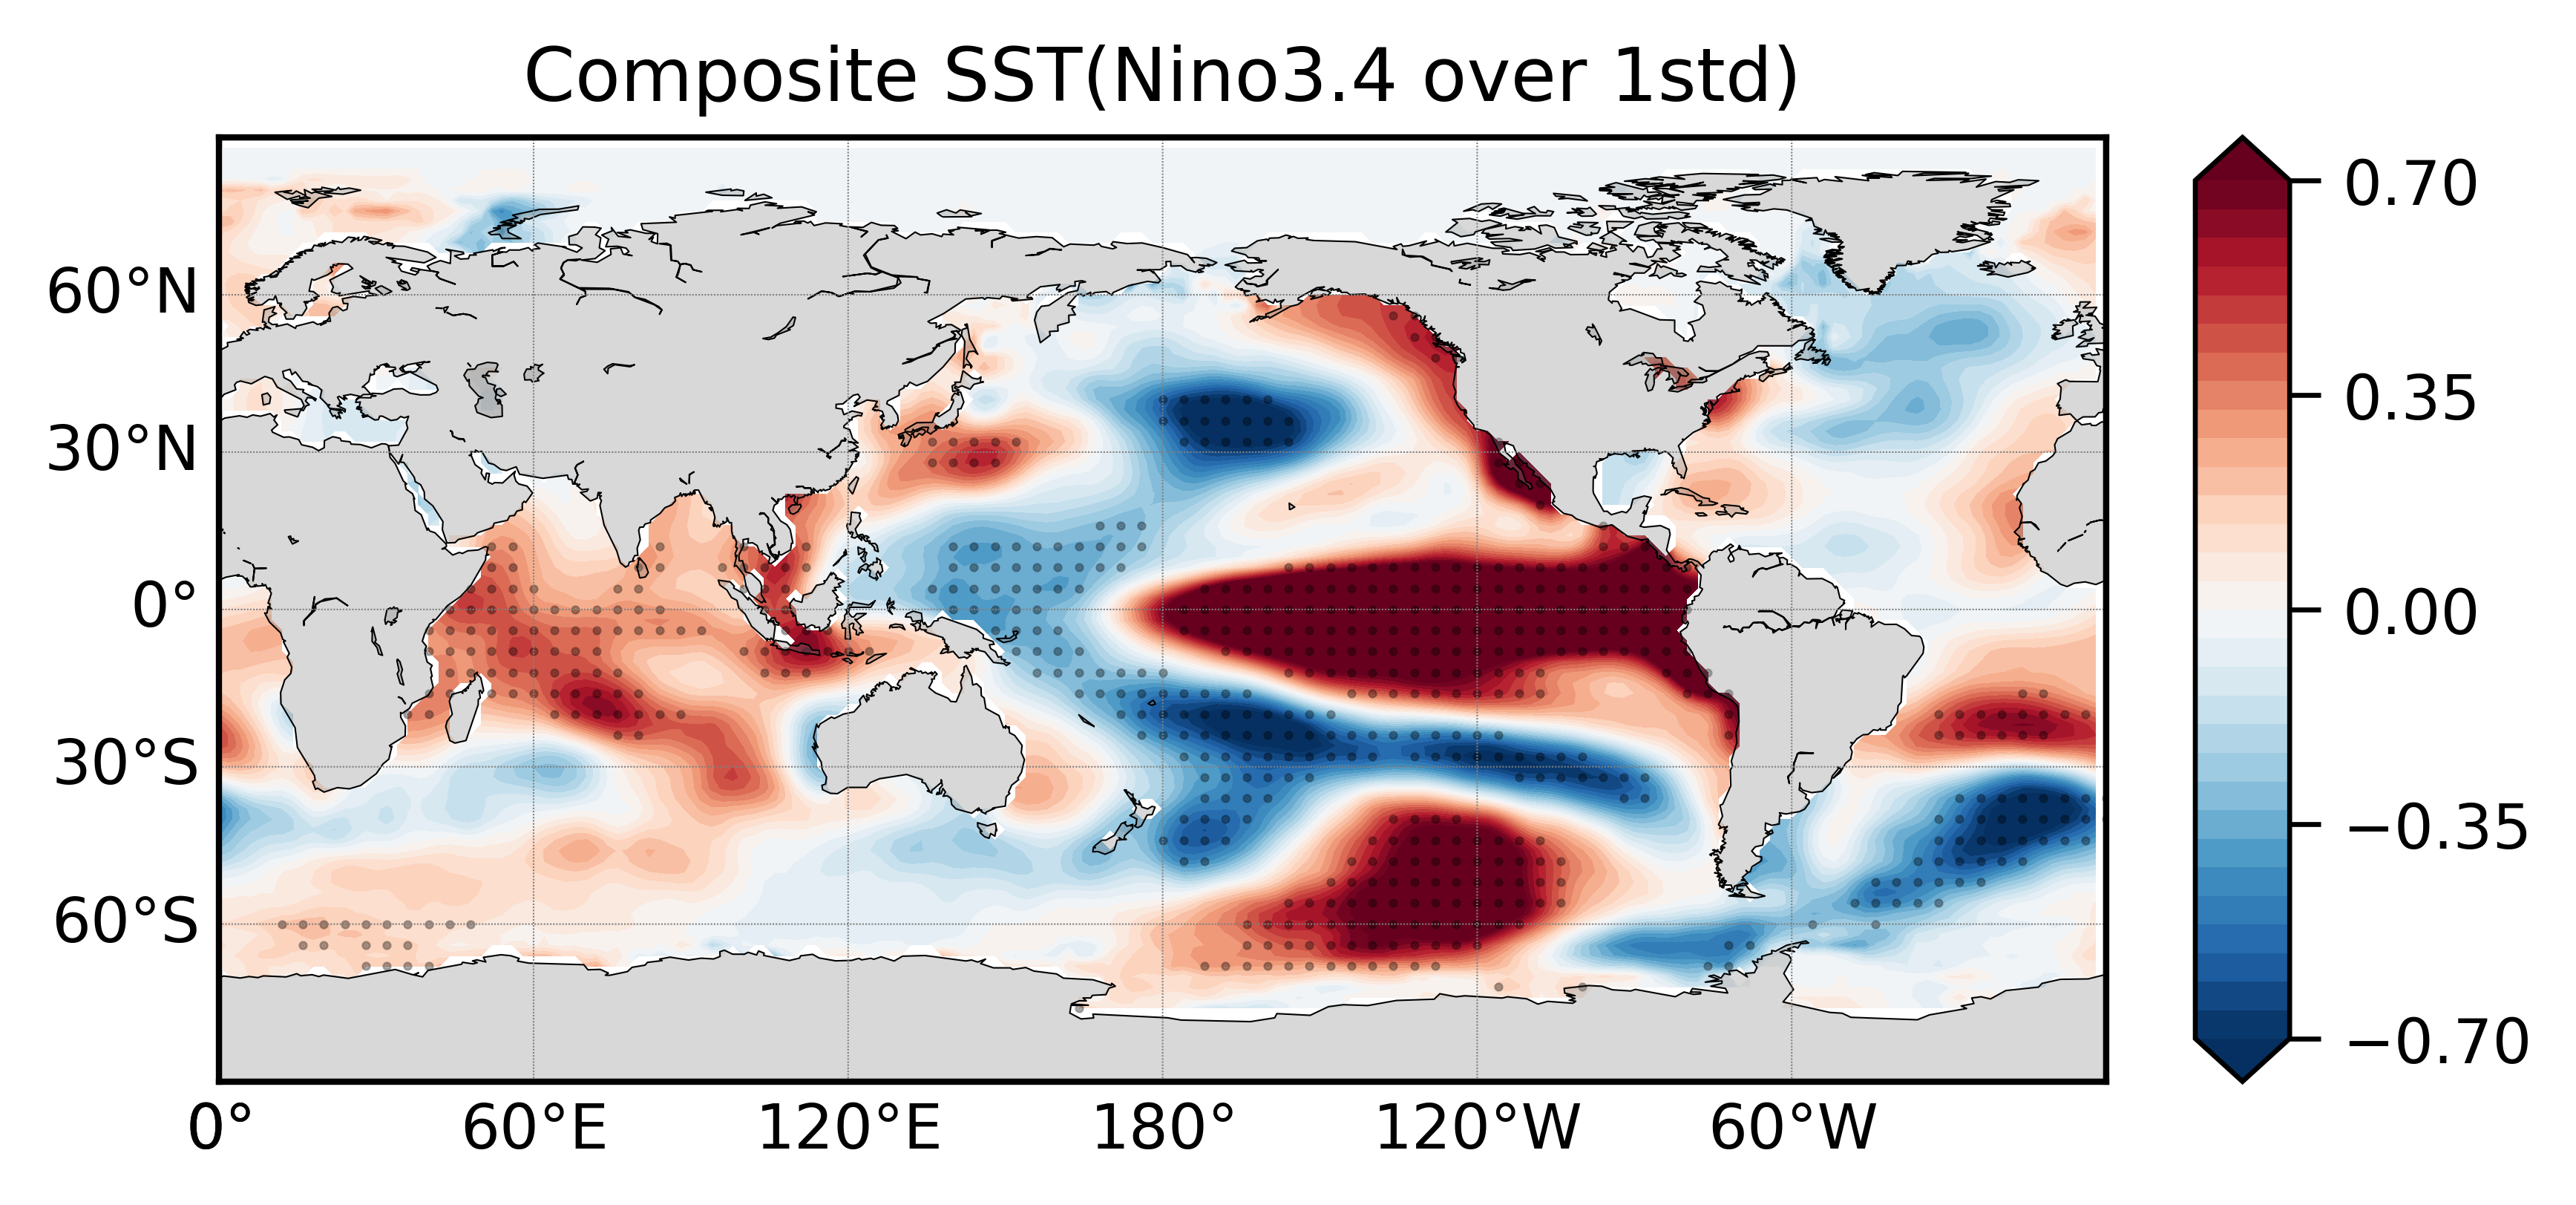

In [12]:
## Plot correlation contour map
cmap         = plt.get_cmap('RdBu_r')
pval_sig_lev = 0.05
lon0         = -180

m = Basemap(projection = 'cyl', lon_0 = lon0, resolution = 'c')
m.fillcontinents(color = 'grey',lake_color = 'grey', alpha = 0.3)
m.drawcoastlines(linewidth = 0.25)
m.drawmapboundary(fill_color = 'white')
m.drawparallels(np.arange(-60.,61.,30.),labels = [1,0,0,0], color = 'grey',linewidth=0.25)
m.drawmeridians(np.arange(-180.,181.,60.),labels = [0,0,0,1], color = 'grey',linewidth=0.25)


contour_shifted, lon_shifted = shiftgrid(180+lon0, comp, lon, start = False, cyclic=360)
lon_new, lat_new = np.meshgrid(lon_shifted,lat)
x, y = m(lon_new,lat_new)
vmin = -0.7 ; vmax = 0.7
nv = 30 ; levels = np.linspace(vmin,vmax,nv+1)
plot = m.contourf(x, y, contour_shifted, cmap = cmap, levels = levels, extend = 'both')    

## Plot significant regions by dots
lat_signi = []; lon_signi = []
for i in range(0,len(lat),2):
    for j in range(0,len(lon),2):
        if (~np.isnan(signi[i,j])):
            lat_signi.append(lat[i])
            lon_signi.append(lon[j])
x, y = m(lon_signi,lat_signi)
m.scatter( x, y, s = 0.8, marker = '.', color = 'black', alpha = 0.4, latlon = True )

## Detail plot properties    
cbar = m.colorbar(plot, location = 'right', aspect = 35, pad = 0.2)
cbar.set_ticks([-0.70,-0.35,0.0,0.35,0.70])
cbar.ax.tick_params( length = 5, labelsize = 10)

plt.title("Composite SST(Nino3.4 over 1std)",fontsize=12)

## <Save Correaltion Map Figure to RESULT directory
dir_name   =  "./"
file_name  =  "Map_Comp_DJF_Nino34_SST.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)

## SST Composite with Nino3.4(over 1 std)

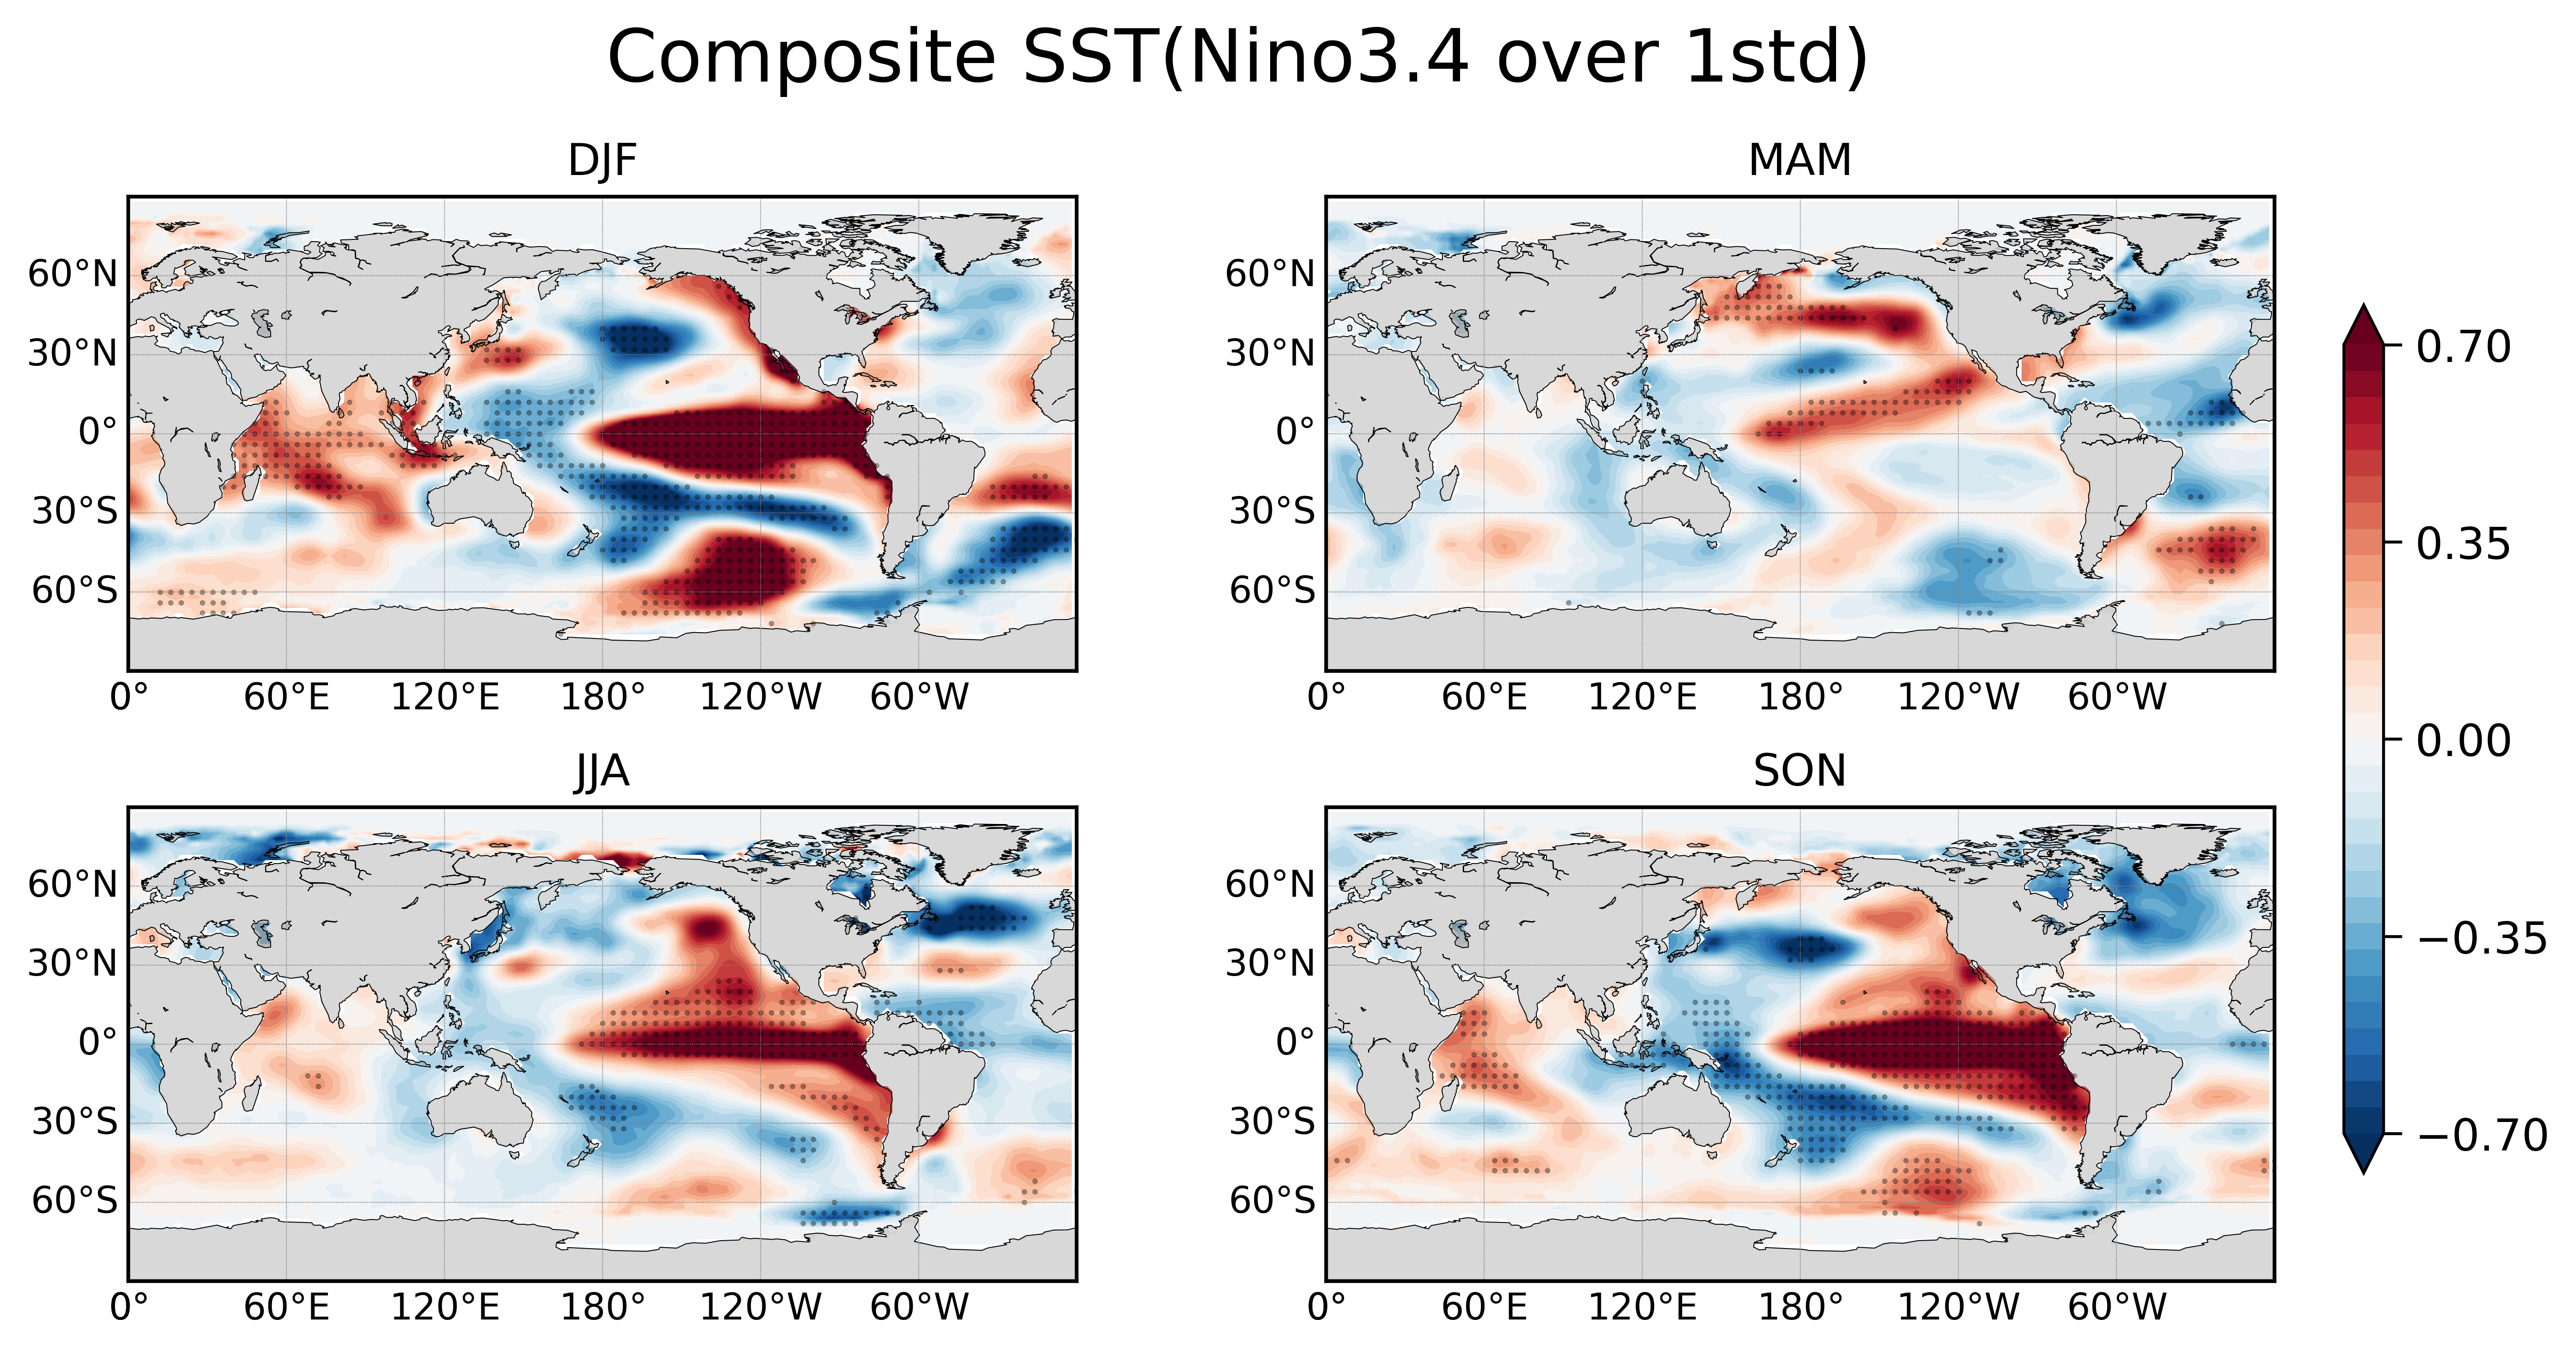

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10,5), constrained_layout = True )
season = ["DJF","MAM","JJA","SON"]

##year index(DJF nino34 index over 1 std)
nino34 = nino34 / nino34.std()
ind_ts  =  np.where(nino34 >= 1.0)[0]

for sea in range(4):
    ind_x = sea//2
    ind_y = sea%2

    if (season[sea]=="DJF"):
        SST_season_all = anom_SST.where(anom_SST['time.season'] == 'DJF')
        SST_season    = SST_season_all.rolling(min_periods=3, center=True, time=3).mean()
        SST_season[0] = SST_season_all[0:2].mean()
        SST_season = SST_season.groupby('time.year').mean('time')
        SST_season = SST_season[1::]
    else:
        SST_season_all = anom_SST.where(anom_SST['time.season'] == season[sea])
        SST_season = SST_season_all.groupby('time.year').mean('time')
        SST_season =  SST_season[0:-1]

    ##composite
    comp = SST_season[ind_ts].mean("year")
    nboot = 10000
    tmp_sig_lev = 0.05

    n1_dims = SST_season.values.shape; n1 = n1_dims[0]
    n2_dims = SST_season[ind_ts].values.shape; n2 = n2_dims[0]
    ny = n1_dims[1]; nx = n1_dims[2]
    boot = np.empty([nboot,ny,nx])
    n_tail = round(nboot*(0+tmp_sig_lev/2.0))
    n_head = round(nboot*(1-tmp_sig_lev/2.0))
    
    for i in range(nboot):
        random_id = np.random.choice( np.arange(0,n1,1), replace = True, size = n2 )
        boot[i,:,:] = SST_season[random_id,:,:].mean( axis = 0 )

    boot_sorted = np.sort( boot, axis = 0 )

    boot_tail = boot_sorted[n_tail,:,:]
    boot_head = boot_sorted[n_head,:,:]
    signi = np.where( (comp > boot_head) | (comp < boot_tail), comp, np.nan )

    ## Plot correlation contour map
    cmap         = plt.get_cmap('RdBu_r')
    pval_sig_lev = 0.05
    lon0         = -180

    m = Basemap(projection = 'cyl', lon_0 = lon0, resolution = 'c', ax = axes[ind_x][ind_y])
    m.fillcontinents(color = 'grey',lake_color = 'grey', alpha = 0.3)
    m.drawcoastlines(linewidth = 0.25)
    m.drawmapboundary(fill_color = 'white')
    m.drawparallels(np.arange(-60.,61.,30.),labels = [1,0,0,0], color = 'grey',linewidth=0.25)
    m.drawmeridians(np.arange(-180.,181.,60.),labels = [0,0,0,1], color = 'grey',linewidth=0.25)

    contour_shifted, lon_shifted = shiftgrid(180+lon0, comp, lon, start = False, cyclic=360)
    lon_new, lat_new = np.meshgrid(lon_shifted,lat)
    x, y = m(lon_new,lat_new)
    vmin = -0.7 ; vmax = 0.7
    nv = 30 ; levels = np.linspace(vmin,vmax,nv+1)
    plot = m.contourf(x, y, contour_shifted, cmap = cmap, levels = levels, extend = 'both')

    ## Plot significant regions by dots## DJF SST Composite with Nino3.4(over 1 std)
    lat_signi = []; lon_signi = []
    for i in range(0,len(lat),2):
        for j in range(0,len(lon),2):
            if (~np.isnan(signi[i,j])):
                lat_signi.append(lat[i])
                lon_signi.append(lon[j])
    x, y = m(lon_signi,lat_signi)
    m.scatter( x, y, s = 0.8, marker = '.', color = 'black', alpha = 0.4, latlon = True )
    axes[ind_x][ind_y].set_title(season[sea])

## Detail plot properties    
cbar = fig.colorbar(plot, location = 'right', ax = axes, shrink = 0.80, aspect = 35, pad = 0.02 )
cbar.set_ticks([-0.70,-0.35,0.0,0.35,0.70])
cbar.ax.tick_params( length = 5, labelsize = 12 )

fig.suptitle("Composite SST(Nino3.4 over 1std)",fontsize=20)

## <Save Correaltion Map Figure to RESULT directory
dir_name   =  "./"
file_name  =  "Map_Comp_Nino34_SST.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)